In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from data.ffs.readParameters import readParametersFromFileName
from ffsInference import ffsInference
parameterDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
from upt.datasets.ffs_dataset import ffsDataset


In [2]:
from upt.datasets.ffs_dataset import ffsDataset

# crop_values= [[-6, -2], [12, 2]]
crop_values= [[-5, -2], [5, 2]]

xMin = crop_values[0][0]
xMax = crop_values[0][1]

test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessed/SST",
    # root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    num_inputs=float("inf"),
    # num_inputs=10000,
    # how many outputs to use for training
    num_outputs=float("inf"),
    # num_outputs=10000,
    mode="test",
    crop_values=crop_values,
    useMesh=None,
    use_inferencer_inputs=False
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=512, deterministic=True),
)

In [3]:
idx = 0
batch = test_dataloader.__iter__().__next__()
for i in range(idx):
    batch = batch.__next__()

for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.type()}")

input_pos: torch.FloatTensor
input_feat: torch.FloatTensor
supernode_idxs: torch.LongTensor
batch_idx: torch.LongTensor
output_pos: torch.FloatTensor
target_feat: torch.FloatTensor
dCp: torch.FloatTensor
re: torch.FloatTensor


In [7]:
batch['input_pos']

tensor([[ 99.2539, 123.1350],
        [ 99.0105, 123.1350],
        [ 99.4258, 123.5645],
        ...,
        [198.9600,  75.0000],
        [199.9820,  75.0000],
        [199.9820,  75.0000]])

In [3]:
reArray = []
for batch in test_dataloader:
    input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
    input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])
    output_pos = test_hr_dataset.denormalize_pos(batch['output_pos'][0])
    target_feat = test_hr_dataset.denormalize_feat(batch['target_feat'])
    re = test_hr_dataset.denormalize_re(batch['re'])
    parameterDict = readParametersFromFileName(batch['name'][0], parameterDef)
    reFile = parameterDict['re']
    Lo = parameterDict['Lo']
    Ho = parameterDict['Ho']
    reArray.append(batch['re'].item())
    # reArray.append(re.item())
    # reArray.append(reFile)
    # print('re data', re)
    # print('re file', reFile)
    
    # print(batch['name'][0])
    
reArray = np.array(reArray)
print('re max: ', reArray.max())
print('re min: ', reArray.min())
print('re mean: ', reArray.mean())
print('re std: ', reArray.std())
# print('re array', reArray)

re max:  198.1666666666686
re min:  0.16666666666664243
re mean:  97.55972222222262
re std:  61.75982751244813


In [3]:
idx = 0
batch = test_dataloader.__iter__().__next__()
for i in range(idx):
    batch = batch.__next__()

input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])
output_pos = test_hr_dataset.denormalize_pos(batch['output_pos'][0])
target_feat = test_hr_dataset.denormalize_feat(batch['target_feat'])
re = test_hr_dataset.denormalize_re(batch['re'])
parameterDict = readParametersFromFileName(batch['name'][0], parameterDef)
reFile = parameterDict['re']
Lo = parameterDict['Lo']
Ho = parameterDict['Ho']
# print(re)
# print(batch['name'][0])

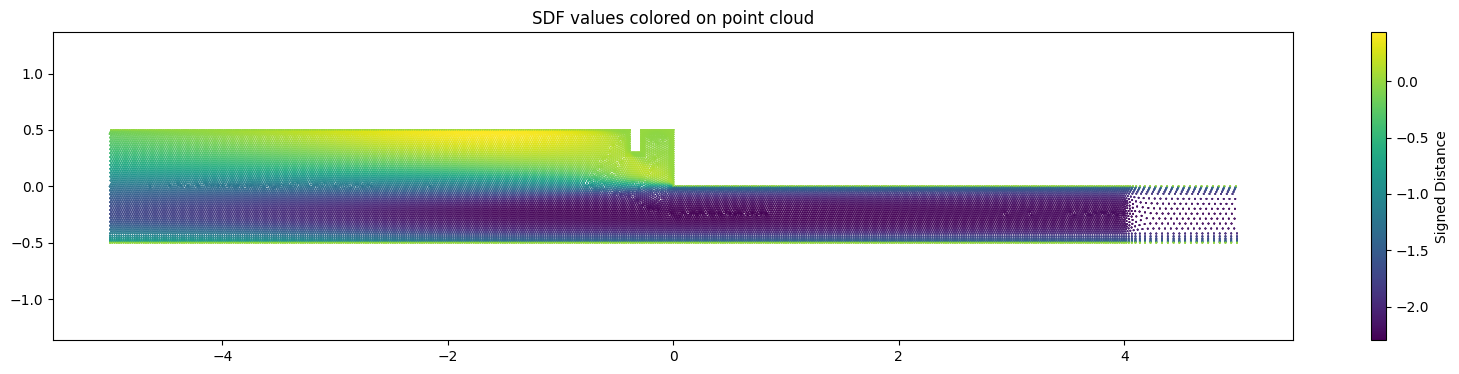

In [6]:
var = target_feat[:, 0].numpy()
coord = output_pos
# Visualize
plt.figure(figsize=(20, 4))
plt.scatter(coord[:, 0], coord[:, 1], c=var, s=0.1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

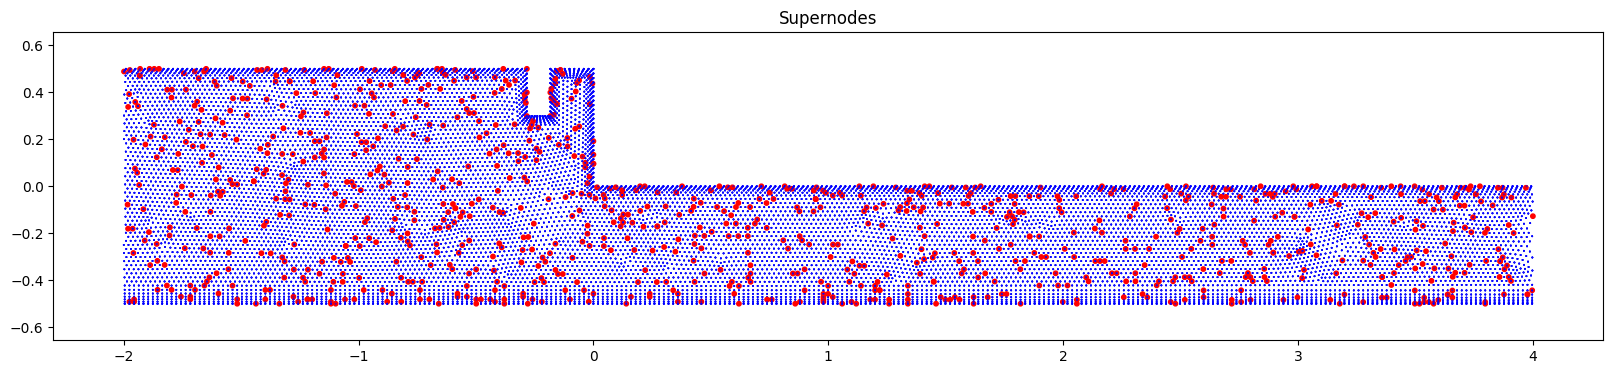

In [15]:
supernode_idxs = batch['supernode_idxs']
var = np.zeros_like(input_feat)+ 0.1
color = np.zeros_like(input_feat)
var[supernode_idxs] = 10
color[supernode_idxs] = 1
coord = input_pos
# Visualize
plt.figure(figsize=(20, 4))
plt.scatter(coord[:, 0], coord[:, 1], c=color, cmap='bwr', s=var)
# plt.colorbar(label="Supernodes")
plt.axis("equal")
plt.title("Supernodes")
plt.show()

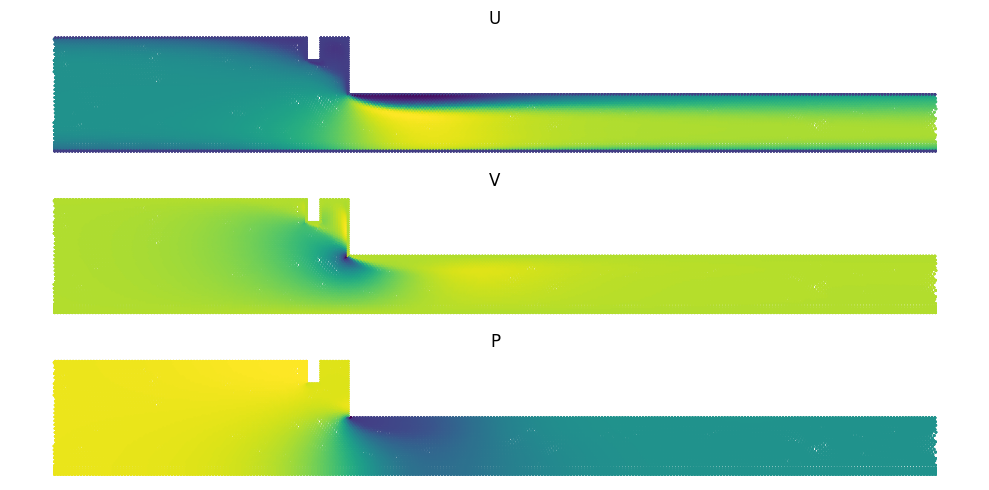

In [16]:
coord = output_pos
var= target_feat
# Visualize
_, axes = plt.subplots(3, 1, figsize=(10, 5)) #, figsize=(10, 2)
axes[0].scatter(coord[:, 0], coord[:, 1], c=var[:,0], s=1)
axes[0].set_title("U")
axes[0].set_axis_off()
axes[1].scatter(coord[:, 0], coord[:, 1], c=var[:,1], s=1)
axes[1].set_title("V")
axes[1].set_axis_off()
axes[2].scatter(coord[:, 0], coord[:, 1], c=var[:,2], s=1)
axes[2].set_title("P")
axes[2].set_axis_off()
# plt.colorbar(ax=axes[2], orientation="horizontal")
plt.tight_layout()
# plt.colorbar()
# plt.title(test_batch["name"])
plt.show()


In [17]:
input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])
output_pos = test_hr_dataset.denormalize_pos(batch['output_pos'][0])
target_feat = test_hr_dataset.denormalize_feat(batch['target_feat'])

print("Input position shape: \n", input_pos.shape)
print("Input position 1-5:\n", input_pos[:5], "\n")

print("Input feature shape: \n", input_feat.shape)
print("Input feature 1-5:\n", input_feat[:5], "\n")

print("Output position shape: \n", output_pos.shape)
print("Output position 1-5:\n", output_pos[:5], "\n")

print("Target feature shape: \n", target_feat.shape)
print("Target feature 1-5:\n", target_feat[:5], "\n")

Input position shape: 
 torch.Size([54560, 2])
Input position 1-5:
 tensor([[-0.0373,  0.4627],
        [-0.0495,  0.4627],
        [-0.0287,  0.4713],
        [-0.0428,  0.4713],
        [-0.0373,  0.4627]]) 

Input feature shape: 
 torch.Size([54560, 1])
Input feature 1-5:
 tensor([[0.0277],
        [0.0319],
        [0.0206],
        [0.0246],
        [0.0277]]) 

Output position shape: 
 torch.Size([54560, 2])
Output position 1-5:
 tensor([[-0.0373,  0.4627],
        [-0.0495,  0.4627],
        [-0.0287,  0.4713],
        [-0.0428,  0.4713],
        [-0.0373,  0.4627]]) 

Target feature shape: 
 torch.Size([54560, 3])
Target feature 1-5:
 tensor([[-8.9234e-03,  7.8284e-03,  2.3555e+00],
        [-1.8216e-02,  1.3213e-02,  2.3556e+00],
        [ 3.8555e-03, -2.3168e-03,  2.3554e+00],
        [-3.2398e-03,  6.3366e-03,  2.3555e+00],
        [-8.9233e-03,  7.8282e-03,  2.3555e+00]]) 



In [10]:
from pathlib import Path
import torch
root = Path('./data/ffs/preprocessed/SST/')

vars_norm = torch.load(root/'vars_norm.th', weights_only=True)
print("vars_norm: ", vars_norm)

vars_norm:  {'mean': tensor([ 1.1623e+00, -2.2337e-02,  1.5570e+00,  1.7293e-01,  3.0000e+04]), 'std': tensor([6.3616e-01, 1.1401e-01, 9.8184e-01, 1.4404e-01, 2.8855e+03])}
